In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, './simile')

import simile as sml

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from rdkit.Chem import MolFromSmiles, rdFMCS

## Load Data

In [2]:
df = pd.read_json('./example_data/fig5a.json')

mzi1 = np.array(df.iloc[0].spectrum)
mzi2 = np.array(df.iloc[1].spectrum)

pmz1 = df.iloc[0].precursor_mz
pmz2 = df.iloc[1].precursor_mz

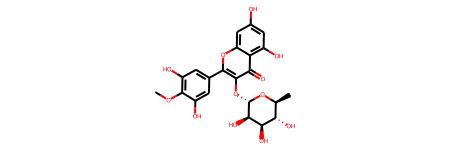

In [3]:
mol1 = MolFromSmiles(df.iloc[0].smiles)
mol1

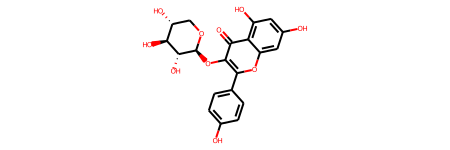

In [4]:
mol2 = MolFromSmiles(df.iloc[1].smiles)
mol2

## MCS Jaccard Similarity

In [5]:
res = rdFMCS.FindMCS([mol1,mol2],timeout=10,ringMatchesRingOnly=False)
A = mol1.GetNumBonds()
B = mol2.GetNumBonds()
AB = res.numBonds
jaccard_similarity = AB / ((A+B) - AB)
jaccard_similarity

0.8918918918918919

## SIMILE Substitution Matrix, Alignment Score, and Alignment P-value

Score: 0.844127595775341, P-value: 0.012


<AxesSubplot:>

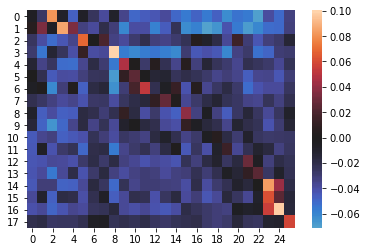

In [6]:
S = sml.substitution_matrix(mzi1[0], mzi2[0], tolerance=.01)

simile_score,simile_alignment = sml.pairwise_align(S[:mzi1.shape[1],mzi1.shape[1]:])
simile_pval = sml.alignment_test(S, mzi1[0], mzi2[0])

print('Score: {}, P-value: {}'.format(simile_score, simile_pval))
sns.heatmap(S[:mzi1.shape[1],mzi1.shape[1]:],center=0,linewidths=0.0, rasterized=True)

## SIMILE Alignment MZs and MZ Differences

In [7]:
np.set_printoptions(suppress=True)
np.array([mzi1[0,simile_alignment.T[1]],
          mzi2[0,simile_alignment.T[0]],
          mzi1[0,simile_alignment.T[1]]-
          mzi2[0,simile_alignment.T[0]]]).T

array([[477.1037, 417.0805,  60.0232],
       [358.0327, 327.0492,  30.9835],
       [330.0381, 299.0545,  30.9836],
       [316.0224, 285.0388,  30.9836],
       [315.0149, 284.0312,  30.9837],
       [288.0276, 257.0442,  30.9834],
       [287.0198, 256.0364,  30.9834],
       [270.0171, 239.0338,  30.9833],
       [259.0251, 228.0417,  30.9834],
       [244.0379, 213.0547,  30.9832],
       [243.0299, 212.0469,  30.983 ],
       [242.0221, 211.039 ,  30.9831],
       [178.9988, 178.9978,   0.001 ],
       [164.0117, 163.0031,   1.0086],
       [152.0119, 152.011 ,   0.0009],
       [151.0039, 151.003 ,   0.0009]])

## Modified Cosine Alignment MZs and MZ Differences

In [8]:
modcos_alignment = np.argwhere(np.isclose(np.subtract.outer(mzi2[0],mzi1[0]), 0,         rtol=0,atol=.01)| 
                               np.isclose(np.subtract.outer(mzi2[0],mzi1[0]), pmz2-pmz1, rtol=0,atol=.01))

In [9]:
np.set_printoptions(suppress=True)
np.array([mzi1[0,modcos_alignment.T[1]],
          mzi2[0,modcos_alignment.T[0]],
          mzi1[0,modcos_alignment.T[1]]-
          mzi2[0,modcos_alignment.T[0]]]).T

array([[151.0039, 151.003 ,   0.0009],
       [152.0119, 152.011 ,   0.0009],
       [178.9988, 178.9978,   0.001 ],
       [477.1037, 417.0805,  60.0232]])

## SIMILE (x) vs Modified Cosine (+) Alignment

/Users/dgct/anaconda/envs/simile-example/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


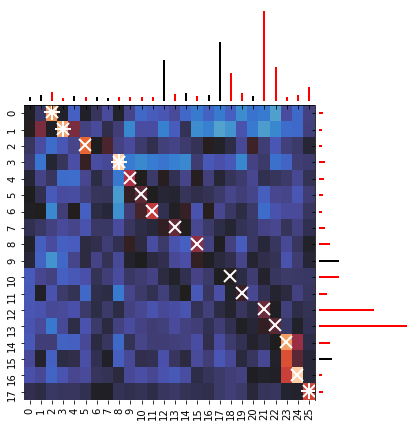

In [10]:
def pairgrid_heatmap(mzs,intensities,S,n,ax, **kws):
    sns.heatmap(S[:n,n:],center=0,ax=ax, cbar=False,linewidths=0.0, rasterized=True)
    
    ax.plot(*modcos_alignment[::-1].T+.45,'w+',markersize=100/len(mzs)**.5,alpha=1,markeredgewidth=2)
    ax.plot(*simile_alignment[::-1].T+.45,'wx',markersize=80/len(mzs)**.5,alpha=1,markeredgewidth=2)
    

mzs,intensities=np.concatenate([mzi1,mzi2],axis=1)
intensities = intensities**.5
n = len(mzi1[0])

p = sns.JointGrid(mzs,intensities,ratio=3,space=0)
p.plot_joint(pairgrid_heatmap, S=S, n=n, ax=p.ax_joint, cax=p.ax_marg_y, fig=p.fig)

p.ax_marg_x.vlines(np.arange(len(intensities)-n)+.5, 
                   np.zeros_like(intensities[n:]), 
                   intensities[n:],linewidth=2,
                   color='black')
p.ax_marg_x.vlines(simile_alignment[::-1].T[0]+.5, 
                   np.zeros_like(intensities[n:][simile_alignment[::-1].T[0]]), 
                   intensities[n:][simile_alignment[::-1].T[0]],linewidth=2,
                   color='r')

p.ax_marg_y.hlines(np.arange(n)+.5, 
                   np.zeros_like(intensities[:n]), 
                   intensities[:n],linewidth=2,
                   color='black')
p.ax_marg_y.hlines(simile_alignment[::-1].T[1]+.5, 
                   np.zeros_like(intensities[:n][simile_alignment[::-1].T[1]]), 
                   intensities[:n][simile_alignment[::-1].T[1]],linewidth=2,
                   color='r')
